In [71]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 9)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [72]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=50, cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

## Logistic Regression

In [73]:
df = pd.read_csv('nba.csv')
df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,...,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22017,1610612744,GSW,Golden State Warriors,...,25,121,-1,1
1,22017,1610612745,HOU,Houston Rockets,...,16,122,1,1
2,22017,1610612738,BOS,Boston Celtics,...,24,99,-3,1
...,...,...,...,...,...,...,...,...,...
2457,22017,1610612763,MEM,Memphis Grizzlies,...,22,123,-14,1
2458,22017,1610612740,NOP,New Orleans Pelicans,...,20,122,24,1
2459,22017,1610612759,SAS,San Antonio Spurs,...,17,98,-24,1


In [74]:
df_interact(df)

interactive(children=(IntSlider(value=0, description='row', max=2460, step=7), IntSlider(value=0, description=…

(2460 rows, 29 columns) total


In [75]:
display_df(df.iloc[0])

SEASON_ID                            22017
TEAM_ID                         1610612744
TEAM_ABBREVIATION                      GSW
TEAM_NAME            Golden State Warriors
GAME_ID                           21700002
GAME_DATE                       2017-10-17
MATCHUP                        GSW vs. HOU
WL                                       L
MIN                                    240
FGM                                     43
FGA                                     80
FG_PCT                                0.54
FG3M                                    16
FG3A                                    30
FG3_PCT                               0.53
FTM                                     19
FTA                                     21
FT_PCT                                0.91
OREB                                     6
DREB                                    35
REB                                     41
AST                                     34
STL                                      5
BLK        

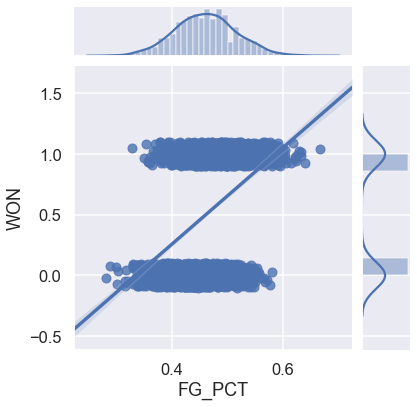

In [76]:
df['WON'] = df['WL'].astype('category').cat.codes
sns.jointplot('FG_PCT', 'WON', data=df, kind='reg', y_jitter=0.1)

This isn't what we're actually interested in. Why not?

In [77]:
half = df[['TEAM_NAME', 'GAME_ID', 'FG_PCT', 'WON']]
pairs = half.groupby('GAME_ID')
games = pairs.first().join(pairs.last(), rsuffix='_OPP')
games.iloc[0]

TEAM_NAME             Boston Celtics
FG_PCT                          0.41
WON                                0
TEAM_NAME_OPP    Cleveland Cavaliers
FG_PCT_OPP                      0.46
WON_OPP                            1
Name: 21700001, dtype: object

In [78]:
games = games.drop('WON_OPP', axis=1)
games['FG_PCT_DIFF'] = games['FG_PCT'] - games['FG_PCT_OPP']
games.iloc[0]

TEAM_NAME             Boston Celtics
FG_PCT                          0.41
WON                                0
TEAM_NAME_OPP    Cleveland Cavaliers
FG_PCT_OPP                      0.46
FG_PCT_DIFF                   -0.049
Name: 21700001, dtype: object

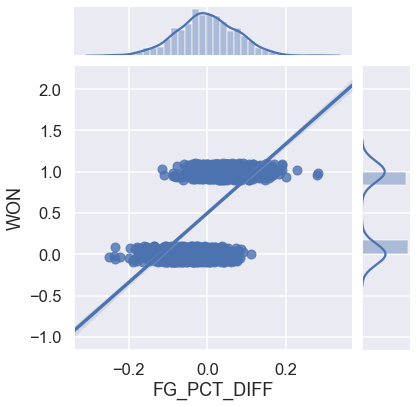

In [79]:
sns.jointplot('FG_PCT_DIFF', 'WON', 
              kind='reg', y_jitter=0.1,
              data=games);

What if we bin the data, then take the proportion of won games in each bin?

In [80]:
bins = pd.cut(games['FG_PCT_DIFF'], 20)
mids = [(b.left + b.right)/2 for b in bins]
games['WON'].groupby(mids).size()

-0.24     4
-0.21     2
-0.18    11
         ..
 0.19     6
 0.24     1
 0.27     2
Name: WON, Length: 19, dtype: int64

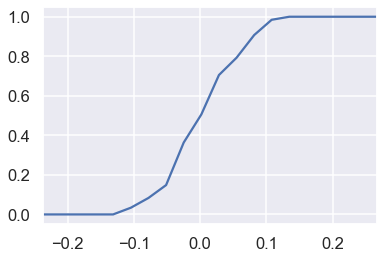

In [81]:
win_rates = games['WON'].groupby(mids).agg(lambda s: sum(s)/len(s))
win_rates.plot();

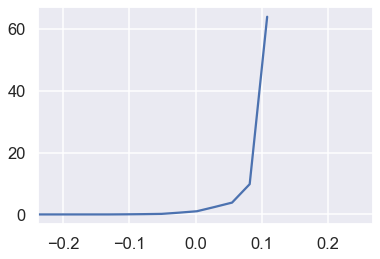

In [82]:
(win_rates / (1 - win_rates)).plot();

/Users/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


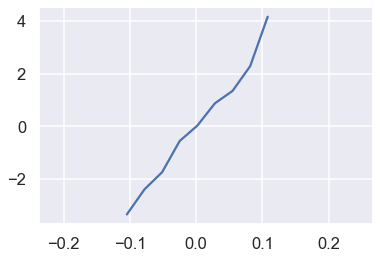

In [83]:
np.log(win_rates / (1 - win_rates)).plot();

One way to model the relationship between vector-valued $X$ and the conditional distribution of a binary categorical $Y \in {0, 1}$ is to assume that the log odds ratio is linear in $X$:

$$\log \left( \frac{P(Y=1|X)}{P(Y=0|X)} \right) = X \cdot \theta$$

Abbreviate $P(Y=1|X)$ as $p$ and $X \cdot \theta$ as $t$, then:

\begin{align*}
\log \left( \frac{P(Y=1|X)}{P(Y=0|X)} \right) &= X \cdot \theta && \text{} \\[10pt]
\log \left( \frac{p}{1-p} \right) &= t && \text{; Abbreviate and complement rule} \\[10pt]
\frac{p}{1-p} &= \exp(t) && \text{; exponentiate both sides} \\[10pt]
p &= \exp(t) - p \exp(t) && \text{; multiply by $1-p$} \\[10pt]
p (1 + \exp(t)) &= \exp(t) && \text{; add $p \exp(t)$ and factor out $p$} \\[10pt]
p &= \frac{\exp(t)}{1 + \exp(t)} && \text{; divide by $1 + \exp(t)$} \\[10pt]
p &= \frac{1}{1 + \exp(-t)} && \text{; multiply by $\frac{\exp(-t)}{\exp(-t)}$} \\[10pt]
P(Y=1|X) &= \frac{1}{1 + \exp(-X \cdot \theta)} && \text{; Unabbreviate}
\end{align*}

This transformation is called the logistic function, traditionally denoted $\sigma$ (sigma).

$$\sigma(t) = \frac{1}{1 + \exp(-t)}$$

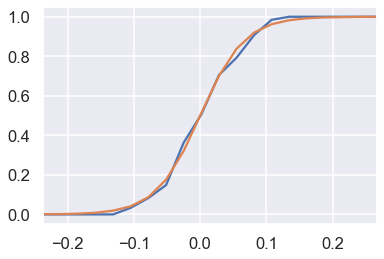

In [84]:
def sigma(t):
    return 1 / (1 + np.exp(-t))

fg_pct_diffs = np.array(win_rates.index)
win_rates.plot();
plt.plot(fg_pct_diffs, sigma(fg_pct_diffs * 30));

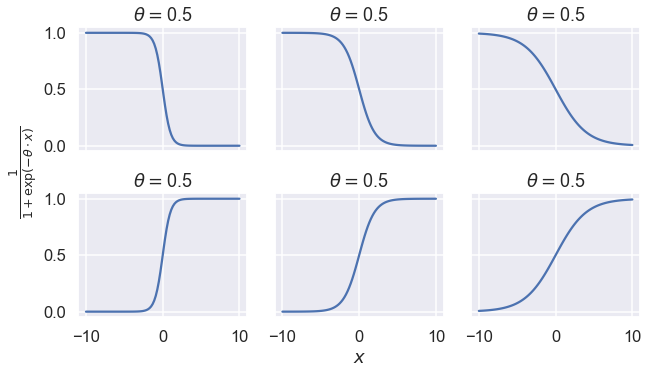

In [85]:
def flatten(li): 
    return [item for sub in li for item in sub]

thetas = [-2, -1, -0.5, 2, 1, 0.5]
xs = np.linspace(-10, 10, 100)

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 6))
for ax, theta in zip(flatten(axes), thetas):
    ys = sigma(xs * theta)
    ax.plot(xs, ys)
    ax.set_title(r'$ \theta = $' + str(b))

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False,
                left=False, right=False)
plt.grid(False)
plt.xlabel('$x$')
plt.ylabel(r'$ \frac{1}{1+\exp(-\theta \cdot x)} $')
plt.tight_layout()

## Log Loss (a.k.a., Cross-Entropy Loss)

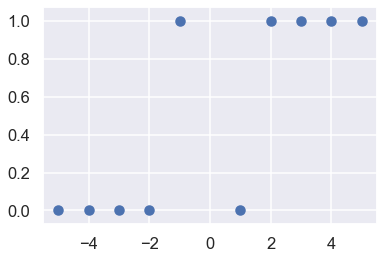

In [86]:
toy = pd.DataFrame({
    'X': [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5],
    'Y': [ 0,  0,  0,  0,  1, 0, 1, 1, 1, 1]
})
plt.scatter(toy['X'], toy['Y']);

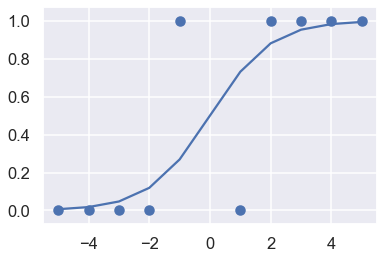

In [87]:
plt.scatter(toy['X'], toy['Y']);
plt.plot(toy['X'], sigma(toy['X']));

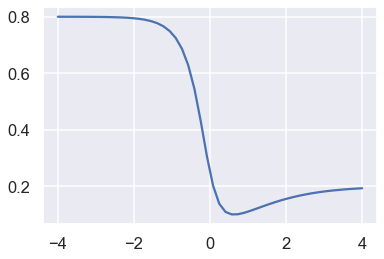

In [88]:
def empirical_risk(theta, loss):
    y_hats = sigma(toy['X'] * theta)
    losses = [loss(y, y_hat) for y, y_hat in zip(toy['Y'], y_hats)]
    return np.average(losses)

def squared_loss(y, y_hat):
    return (y - y_hat) ** 2

thetas = np.linspace(-4, 4, 50)

plt.plot(thetas, [empirical_risk(theta, squared_loss) for theta in thetas]);

Fix an individual and let $\hat{p}$ be our predicted probability of the correct class for that individual. If the individual's class is 1, then $\hat{p}$ is our predicted chance that their class is 1, and if the individual's class is 0, then $\hat{p}$ is our predicted chance that their class is 0.

Regardless of whether the individual's class is 1 or 0, $\hat{p}$ is the predicted chance of the *correct* class. So here are some reasonable stipulations for a loss function.

- If $\hat{p} = 1$ then there should be no loss.
- If $\hat{p}$ is high, the loss should be small.
- If $\hat{p}$ is low, the loss should be large.
- Whatever $\hat{p}$ is, the loss should be non-negative.

Because $\hat{p}$ is between 0 and 1, the function $\hat{p} \rightarrow -\log(\hat{p})$ has all of these properties.

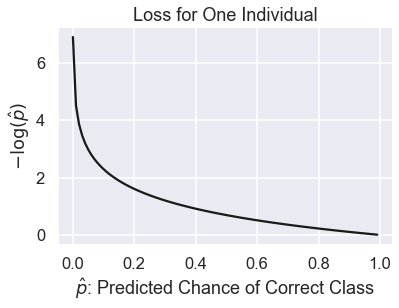

In [89]:
p_hat = np.arange(0.001, 0.999, 0.01)
loss = -np.log(p_hat)
plt.plot(p_hat, loss, color='k')
plt.xlabel('$\hat{p}$: Predicted Chance of Correct Class')
plt.ylabel('$-\log(\hat{p})$')
plt.title('Loss for One Individual');

There are many other functions that have these properties. But this one has other nice properties and interpretations in the context of predictions. You might see some of them in more advanced classes, and you will see one in this class as soon as we start calculating gradients.

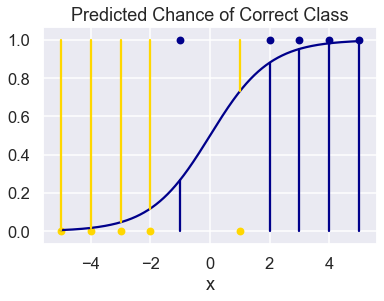

In [90]:
# Predicted chance of class 1.
x = np.arange(-5, 5, 0.01)
px = sigma(x)
plt.plot(x, px, color = 'darkblue')

def add_points(xs, y, color):
    plt.scatter(xs, [y] * len(xs), color=color, s=40)
    for x in xs:
        plt.plot([x, x], [1-y, sigma(x)], color=color)

add_points(np.array([-5, -4, -3, -2, 1]), 0, 'gold')
add_points(np.array([-1, 2, 3, 4, 5]), 1, 'darkblue')
        
plt.xlabel('x')
plt.title('Predicted Chance of Correct Class');

A compact way to write this loss in a single expression, where $y_i$ is the class for individual $i$, is:

$$
-y_i\log(p(x_i)) - (1-y_i)\log(1-p(x_i))
$$

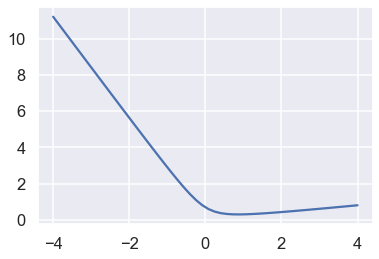

In [91]:
def log_loss(y, y_hat):
    return -y * np.log(y_hat) - (1-y) * np.log(1-y_hat)

plt.plot(thetas, [empirical_risk(theta, log_loss) for theta in thetas]);

## Applying Logistic Regression

In [92]:
games.iloc[0]

TEAM_NAME             Boston Celtics
FG_PCT                          0.41
WON                                0
TEAM_NAME_OPP    Cleveland Cavaliers
FG_PCT_OPP                      0.46
FG_PCT_DIFF                   -0.049
Name: 21700001, dtype: object

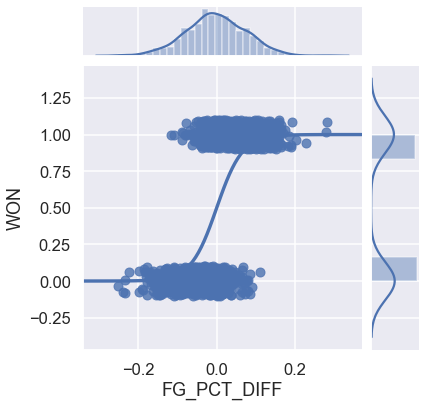

In [93]:
sns.jointplot('FG_PCT_DIFF', 'WON', 
              kind='reg', y_jitter=0.1,
              logistic=True, ci=None,
              data=games);

In [94]:
def predict(theta):
    return sigma(games['FG_PCT_DIFF'] * theta)

def risk(theta):
    y_hat = predict(theta)
    y = games['WON']
    losses = -y * np.log(y_hat) - (1-y) * np.log(1-y_hat)
    return np.average(losses)

In [95]:
from scipy.optimize import minimize

minimize(risk, 1)

      fun: 0.42957549456281086
 hess_inv: array([[3723.16]])
      jac: array([-0.])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 8
     njev: 12
   status: 0
  success: True
        x: array([30.58])

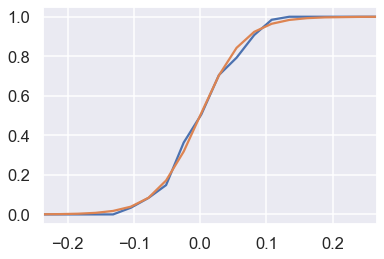

In [96]:
theta = minimize(risk, 1)['x'][0]
win_rates.plot();
plt.plot(fg_pct_diffs, sigma(fg_pct_diffs * theta));